<div style="text-align:center;">
  <div style="color:darkred; font-size:24pt;">
    PAHFIT Demo
   </div><br><br>
    <div  style="font-size:18pt">
    Decomposing NIR-MIR spectroscopy into features
    </div>
</div>

        JWST Webbinar 12/16/2022
        Demo presented by Ameek Sidhu & Dries Van De Putte

## 1. Goal and method

PAHFIT is a python package that can decompose astronomical spectra into emission lines, broad dust features, and continua, including an attenuation law. In practice, the decomposition consists of fitting a multi-component model to the given data, using a chi squared based minimization. This fit results in a set of parameters for each component, describing their properties (e.g. emission strength) while being corrected for the continuum and the attenuation.

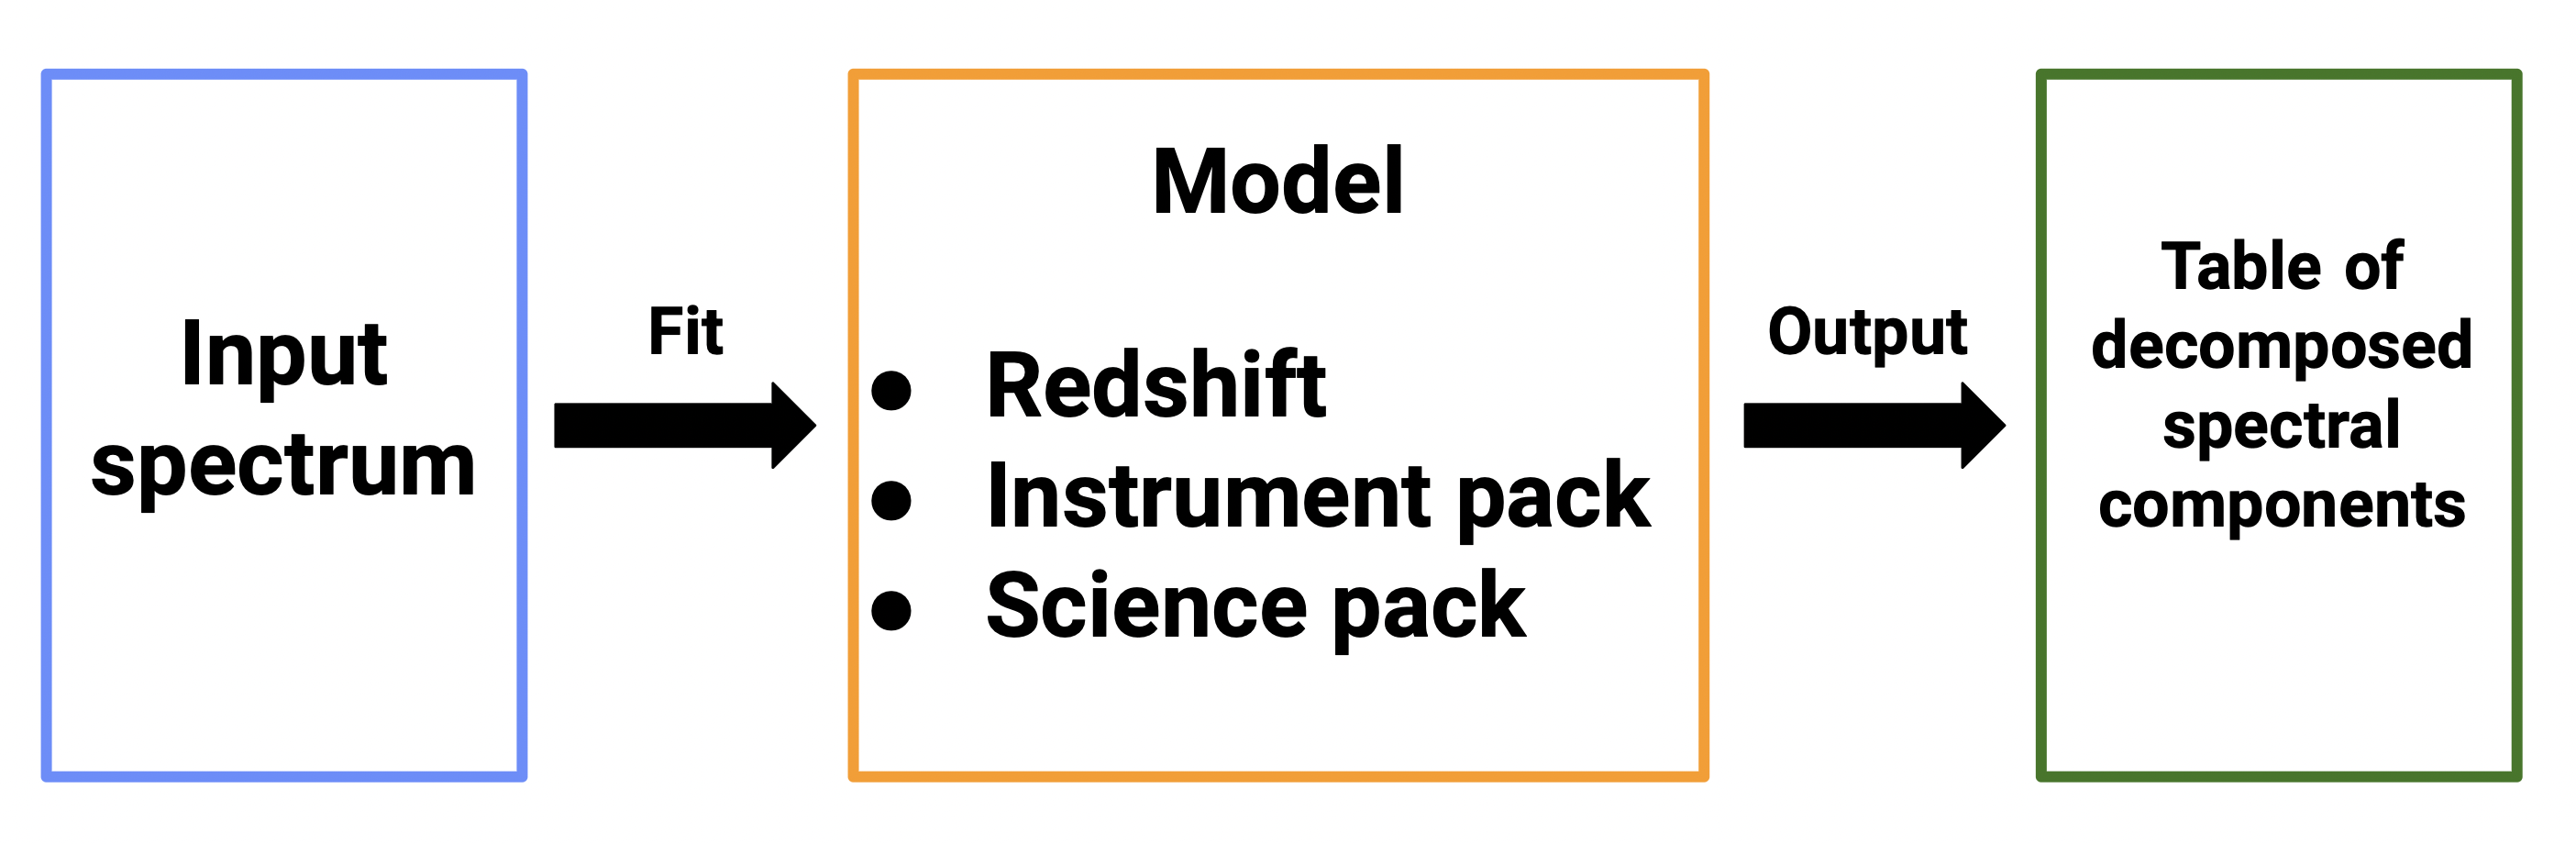
### Model & Science packs
The model is fully customizable, meaning that the features to be fit can be freely added, removed, or adjusted to better match the observable features of the object at hand. PAHFIT comes with several model setups included, which include the most common dust features and lines. These are called science packs.

In the future PAHFIT will provide a variety of default science packs, that cover the most common scientific use cases.

- Current: **classic extragalactic pack**, originally optimized for Spitzer, now generally applicable. Reproduces the results by the original IDL version of PAHFIT.
- Near future: deep and shallow **PDR packs**. Deeper packs include more weak lines, that are only fittable if the data have a sufficient spectral resolution and SNR

### Instrument packs

In the example above, the line features do not have a width specified. This is because appropriate line widths are predicted by the PAHFIT instrument model, which we explain in this section.

PAHFIT comes with several instrument packs, which describe the resolution of the supported instruments as a function of wavelength. These packs contain a fitted polynomial for each instrument setting, each of which approximates the documented resolution curve for that instrument. These curves are used to determine the FWHM of unresolved lines, so that those line widths can remain fixed during the fitting process. This allows for faster and more robust fitting.

Currently the available packs and instrument settings are organized as follows
- ISO
  + SWS
    - AOT6, AOT1: separate model for each speed setting 
- JWST
  + NIRSPEC
    - prism
    - gratings g140, g235, g395: separate models for medium and high
  + MIRI
    - MRS channels 1, 2, 3, 4: separate models for A, B, and C 
- Spitzer
  + IRS
    - SL and LL: separate models for 1, 2, and 3
    - SH and LH

## 2. Using PAHFIT in a nutshell

In case you want to get started with your data immediately, we have provided this brief section of code at the beginning of this notebook. The four variables you need to define are listed here at the start

In [ ]:
spectrumfile = "M101_Nucleus_irs.ipac"
redshift = 0.000804
instrumentname = f"spitzer.irs.*.[12]"
packfile = "classic.yaml"

The code below then applies the flowchart shown above

In [ ]:
# Everything goes through this class
from pahfit.model import Model

# We use Spectrum1D as input
from specutils import Spectrum1D

import os
import matplotlib
# when ipympl is installed, enable interactive plots like this
# %matplotlib widget

In [ ]:
# model setup
model = Model.from_yaml(packfile)

# spectrum setup
spec = Spectrum1D.read(spectrumfile, format='IPAC')
spec.meta['instrument'] = instrumentname
spec.set_redshift_to(redshift)

# fit
model.guess(spec)
model.fit(spec, maxiter=10000)

In [ ]:
# show results and save
display(model)
fn = 'classic_fit.ecsv'
if not os.path.isfile(fn):
    model.save(fn)
    
model.plot(spec)

## 3. Step by step explanation

In this section, we take a closer look at the crucial steps of fitting with PAHFIT:
   
    a. Loading observational data in the right format
    b. Setting up a model compatible with these observations
    c. Performing the fit
    d. Inspecting and/or saving the results

### a. Load spectrum

The input format is the Spectrum1D class from specutils. It provides a straightforward way to deal with the wavelengths, fluxes, and uncertainties. JWST data files are natively supported by `Spectrum1D.read()`. PAHFIT comes with several example spectra, located in `pahfit/data`. To load one of these, a utility function is available in `pahfit.helpers`.

Uncertainties for these spectral data are required. The 'uncertainty' member of a Spectrum1D object should be automatically populated, if the provided data is in a standard format (e.g. IPAC or JWST fits files), and includes uncertainties.

In [ ]:
from pahfit.helpers import read_spectrum

# choose your data here
spectrumfile = "M101_Nucleus_irs.ipac"
spec = read_spectrum(spectrumfile)

# this returns a Spectrum1D, with uncertainties included
display(spec[:2].spectral_axis)
display(spec[:2].flux) # print out the first two wavelengths to show this
display(spec[:2].uncertainty)

### b. Set up the model

To set up a model that is compatible with the data that were just loaded, several choices need to be made.

**1. science pack**

Choose a science pack compatible with the *physical contents* of your data. This means that it needs to contain all of the features that can be observed in the applicable wavelength range. With data of higher resolution and signal-to-noise ratio, a science pack with more features may be required. More information about setting up science packs can be found in the documentation (work in progress), and some examples are given in the "advanced" section at the end of this notebook

For the example data of M101, the 'classic.yaml' science pack was chosen because it is optimized to fit extragalactic targets. Shown below are two fragments from this pack: the H2 lines that are detectable in the data, and the definition of the 7.7 micron PAH complex.

_Snippets from classic.yaml_
```yaml
H2_lines:
    kind: line
    wavelength:
        H2_S(7):    5.5115
        H2_S(6):    6.1088
        H2_S(5):    6.9091
        H2_S(4):    8.0258
        H2_S(3):    9.6649
        H2_S(2):   12.2785
        H2_S(1):   17.0346
        H2_S(0):   28.2207
        
PAH_7.7_cmp:
    kind: dust_feature
    features:
        PAH_7.7a:
            wavelength: 7.42
            fwhm: 0.93492
        PAH_7.7b:
            wavelength: 7.6
            fwhm: 0.3344
        PAH_7.7c:
            wavelength: 7.85
            fwhm: 0.41605
```

**2. instrument model**

Choose an instrument specification compatible with the *observatory and instrument settings*. The instrument is specified as a string, or as a list of strings. Since the included M101 data were observed with Spitzer IRS, and combined from the  LL1, LL2, SL1, and SL2 segments, the correct instrument pack is `spitzer.irs.`, followed by those four combinations (see code below). Generally, every entry in an instrument pack represents on spectroscopic segment of the instrument, and the data specifies what the resolution is at every wavelength. This information is used to determine appropriate widths for the unresolved lines. To find which other options are available, open the `spitzer.yaml` science pack in a text editor, and combine the applicable instrument names as shown below.

_Snippet from spitzer.yaml_
```yaml
    irs:
        sl:
            '1':
                range: [7.51, 14.78]
                coefficients: [0.0, 8.2667]
            '2':
                range: [5.24, 7.6]
                coefficients: [0.0, 16.5333]
            '3':
                range: [7.34, 8.7]
                coefficients: [0.0, 8.2667]
```
```python
    # In python, combine SL1 and SL2 as follows
    instrumentname = ['spitzer.irs.sl.1', 'spitzer.irs.sl.2']
```

You can try out the instrument model by itself by importing instrument

In [ ]:
from pahfit import instrument
# list all available instrument models
# display(instrument.instruments())
# or a glob-based match
display(instrument.instruments("spitzer.irs*[12]"))
# how the fwhm is determined at a certain wavelength
instrument.fwhm("spitzer.irs*[12]", 5.3)[0,0]

**3. Redshift**

The redshift can also be provided, via the spec.redshift attribute. The physical parameters specified by the science pack, and returned by the fit, are defined in the rest frame of the object. PAHFIT then assures consistency with the redshift in the following ways
- Redshift is used to shift the lines specified in the model, to the observer reference frame. This way, line widths can be determined based on the instrument resolution, and lines can be ignored if the redshift causes them to fall outside the instrument wavelength range. 
- For fitting and plotting, the observational data are shifted to the model/object reference frame.

![pahfit-redshift](pahfit-redshift.svg)

Once you have chosen the appropriate science pack and instrument specification, this information can be passed as follows
- The science pack file name is passed to the Model class to set up the model.
- The instrument specification is associated with the spectrum data. This is done by setting the 'instrument' metadata of the Spectrum1D object. PAHFIT will raise an Error if you forget to do this.
- The redshift is set using the set_redshift_to method of Spectrum1D. 

In [ ]:
# This creates a Model instance. 
# The science pack file can be either 
# - a default one (path automatically found)
# - a custom one in your working directory
model = Model.from_yaml("classic.yaml")

# The instrument name needs to be either a string or a list of strings
# This wildcard syntax can be used to specify multiple spectral segments
# It is equivalent to ["spitzer.irs.ll.1", "spitzer.irs.ll2", "spitzer.irs.sl1", "spitzer.irs.sl2"]
instrumentname = f"spitzer.irs.*.[12]"

# add instrument info to the spectrum that was loaded above
spec.meta['instrument'] = instrumentname

# for M101 the redshift only has a minor effect,
# but we include it here for the demonstration
spec.set_redshift_to(0.000804)

### c: Perform initial guess and fit the model

Making an initial guess is optional, but usually necessary, as the default values (zeros) are not fitter-friendly. Guess will use some very simple heuristics (e.g. average flux) to start the fit from non-zero values with the right order of magnitude.

When fit is called, a parametric function is constructed that describes the flux as a function of wavelength. The parameters of this function relate directly to the observables of interest. They are fit to the spectrum the user passes as an argument, and the results are stored in the internal state of the model, in this case model.features. 

    Note: More advanced initial guesses will be implemented in the future. The user can make their own initial guess by directly editing model.features in Python, which is an astropy table.

In [ ]:
model.guess(spec)

In [ ]:
model.fit(spec, maxiter=10000)

### d: Inspect and save the results

Now that the model is in a "fitted" state, the user can interact further with it to save or visualize the results.

We can plot it using the **default plot** function, or look at the numerical values of the fit by inspecting the features table. Note that the plot and feature table can be shown at any point in the lifetime of the model, even before fitting anything. This can be useful to inspect the results of the model setup procedure, or the initial guess. The features table at `model.features` has all the functionality of an astropy table, and can be sliced for easier inspection.

At the date of this demo, there is only one default plotting function that has been implemented, with limited options. Future development of the visualizations will include plotting separate components. **For other visualization ideas, we are open to feedback**.

In [ ]:
# make the classic PAHFIT plot
model.plot(spec)

In [ ]:
# inspect the numbers. You can slice/mask/group them for easy viewing
model.features[model.features['kind'] == 'line']

In [ ]:
# what are the results for the [SIII]_18 line at 18.7 micron?
model.features.loc['[SIII]_18']

**saving is preferentially done to an ecsv file**

In [ ]:
fn = 'classic_fit.ecsv'
model.save(fn, overwrite=True)

## 4. Advanced and future features

### Load saved model

Models can be reloaded from a save file, so that they can be used to make a plot of a previous fit, or to use a previous fit as an advanced initial guess.

In [ ]:
model_loaded = Model.from_saved("classic_fit.ecsv")
display(model_loaded)
# inspect previous results
# model_loaded.plot(spec)
# do another fit
# model_loaded.fit(spec)

### Editing the YAML science pack

It is expected that users will have specific use cases for which the default packs do not work perfectly. Therefore we recommend that you copy one of the default packs to your working directory, and edit it to your needs. The science packs are defined in YAML, and are designed to be human-readable and human-editable.

Typical edits include
- Adding more features
- Allowing the wavelength or width of a feature to vary, by setting lower and upper bounds
- Change the continuum (blackbody) components
- Add/remove an attenuation model

A couple of examples are provided below. Currently, the most complete overview of the YAML science pack format is located on the [PAHFIT wiki](https://github.com/PAHFIT/pahfit/wiki/PAHFIT-2022)

#### Flexible line wavelengths
```yaml
cool_lines:
    # original
    wavelength:
        cool_line1: 9.7
        other_line: 10.2
    # ADDED   
    bounds:
        # add bounds for all lines in this group like this
        wavelength: [-0.03%, 0.03%]
```

#### Try to find width/wavelength of a dust feature
```yaml
PAH_3.39:
    kind: dust_feature
    wavelength: 3.395
    fwhm: 0.00995
    bounds:
        fwhm: [0.008, 0.009953]
        wavelength: [3.394, 3.396]
```

#### Add many lines with auto-generated names

E.g. you just add the wavelengths you don't know, and plan to name them later once they fit well.
```yaml
unknown:
    kind: line
    wavelength: [ 5.138, 4.296, 4.377, 4.694, 4.672, 4.618, 3.099, 3.164, 3.190, 2.894, 2.613, 2.5645, 3.3488, 3.4536, 3.4678, 3.4849, 3.5018, 3.5226, 3.4386, 3.5468, 3.5748, 3.6073, 3.6271, 3.6470, 3.6629, 3.6936, 5.1297 ]
    bounds:
        wavelength: [-0.1%, 0.1%]
```
#### Add/Remove attenuation from model

```yaml
# just comment out all of this
silicate:
    kind: attenuation
    model: S07_attenuation
    geometry: mixed
    bounds:
        tau: [0, 10]
```   

### Exporting spectral components

The `sub_model()` function will return a functional (flux as a function of wavelength) including only features of the requested kind. When kind is set to "dust_feature", we obtain a functional representation of the combined emission spectrum of all the dust features.

We can use this function to tabulate the flux of the fitted model.

In [ ]:
# the instrument and redshift are still required here, to keep only the features that were fit in the data range
df = model_loaded.sub_model(instrumentname=spec.meta['instrument'], 
                            redshift=spec.redshift,
                            kind='dust_feature')

In the plot below, observe how the extracted dust features around 10 micron are much brighter than observed in the data. This is because of the attenuation correction.

In [ ]:
from matplotlib import pyplot as plt

# evaluate the flux at rest wavelengths, using redshift
oneplusz = 1 + spec.redshift
wrest = spec.spectral_axis.value / oneplusz

def flux_model_plot(func):
    plt.figure()
    # raw data
    plt.plot(spec.spectral_axis.value, spec.flux.value, ls='none', marker='.', ms=2, color='xkcd:light red', label='data')
    # data shifted to rest frame
    plt.plot(wrest, spec.flux.value * oneplusz, ls='none', marker='.', ms=2, color='k', alpha=0.5, label='data z-corrected')
    # model evaluated in rest frame
    plt.plot(wrest, func(wrest), label='model without z, attenuation')
    plt.gcf().set_size_inches(10, 4)
    #plt.ylim([0, 0.1])
    plt.legend()
    plt.show()

In [ ]:
flux_model_plot(df)

In [ ]:
# save the flux using astropy table
from astropy.table import Table
t = Table()
t.add_column(wrest * spec.spectral_axis.unit, name='WAVELENGTH')
t.add_column(df(wrest) * spec.flux.unit, name='FLUX')
t.write('m101_dust_features.ecsv', format='ascii.ecsv', overwrite=True)

#### PAH components extracted from VV114 MIRI MRS 

See the next notebook of this session, about PyPAHdb.

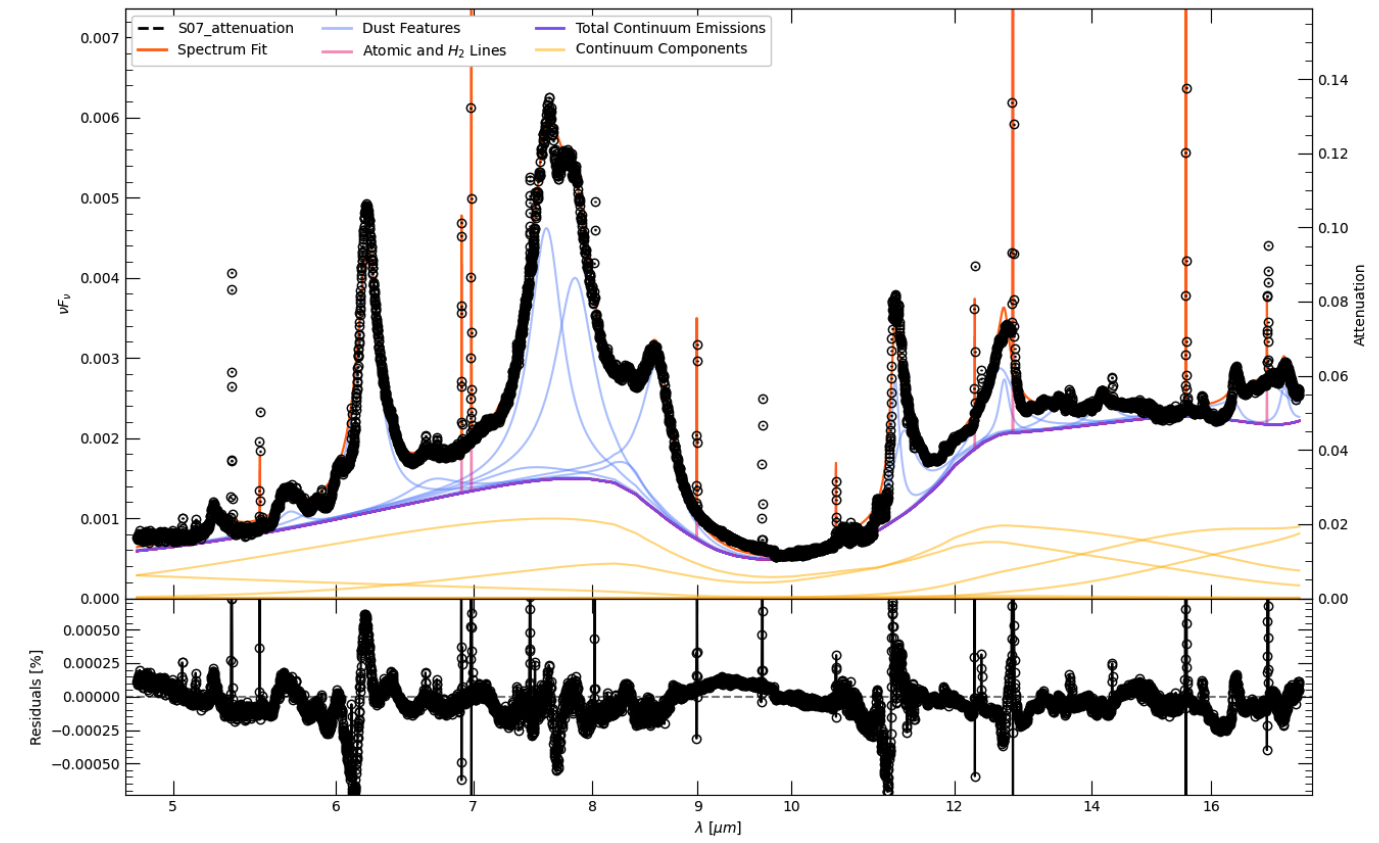

### Uncertainties

While not available at the moment, uncertainties will be included in the final product.

Providing robust uncertainties on the fit parameters is one of the requirements of PAHFIT. For this purpose, an MCMC sampling routine has already been demonstrated within the development team, and faster approximate method are being investigated. 

### Cube fitting

A separate package (https://github.com/drvdputt/PAHFITcube) is under development. It essentially applies PAHFIT to every spaxel of a given data cube, and provides tools to deal with the bookkeeping of all these fits.

There are utilities to run the fits in parallel, restart a partially completed fitting procedure, and some tools to quickly visualize the results (even if all the fits have not been completed yet. The final collection of fits can be summarized as a multi-extension fits file, where each extension is a different feature map. 


#### Example: feature maps of the the Orion bar

The image below shows an example of what is to come, and was created using one of the built-in plotting functions of PAHFITcube.

Some stats: 
- 9 nirspec pointings
- 9000+ fits to F290LP data (approx 3-5 micron)
- 10-20 hours of runtime, on 16 cores

In order: dust features at different central wavelength (PAHs etc.), some vibrationally excited H2 lines, and two HI lines (tracers of ionized medium).

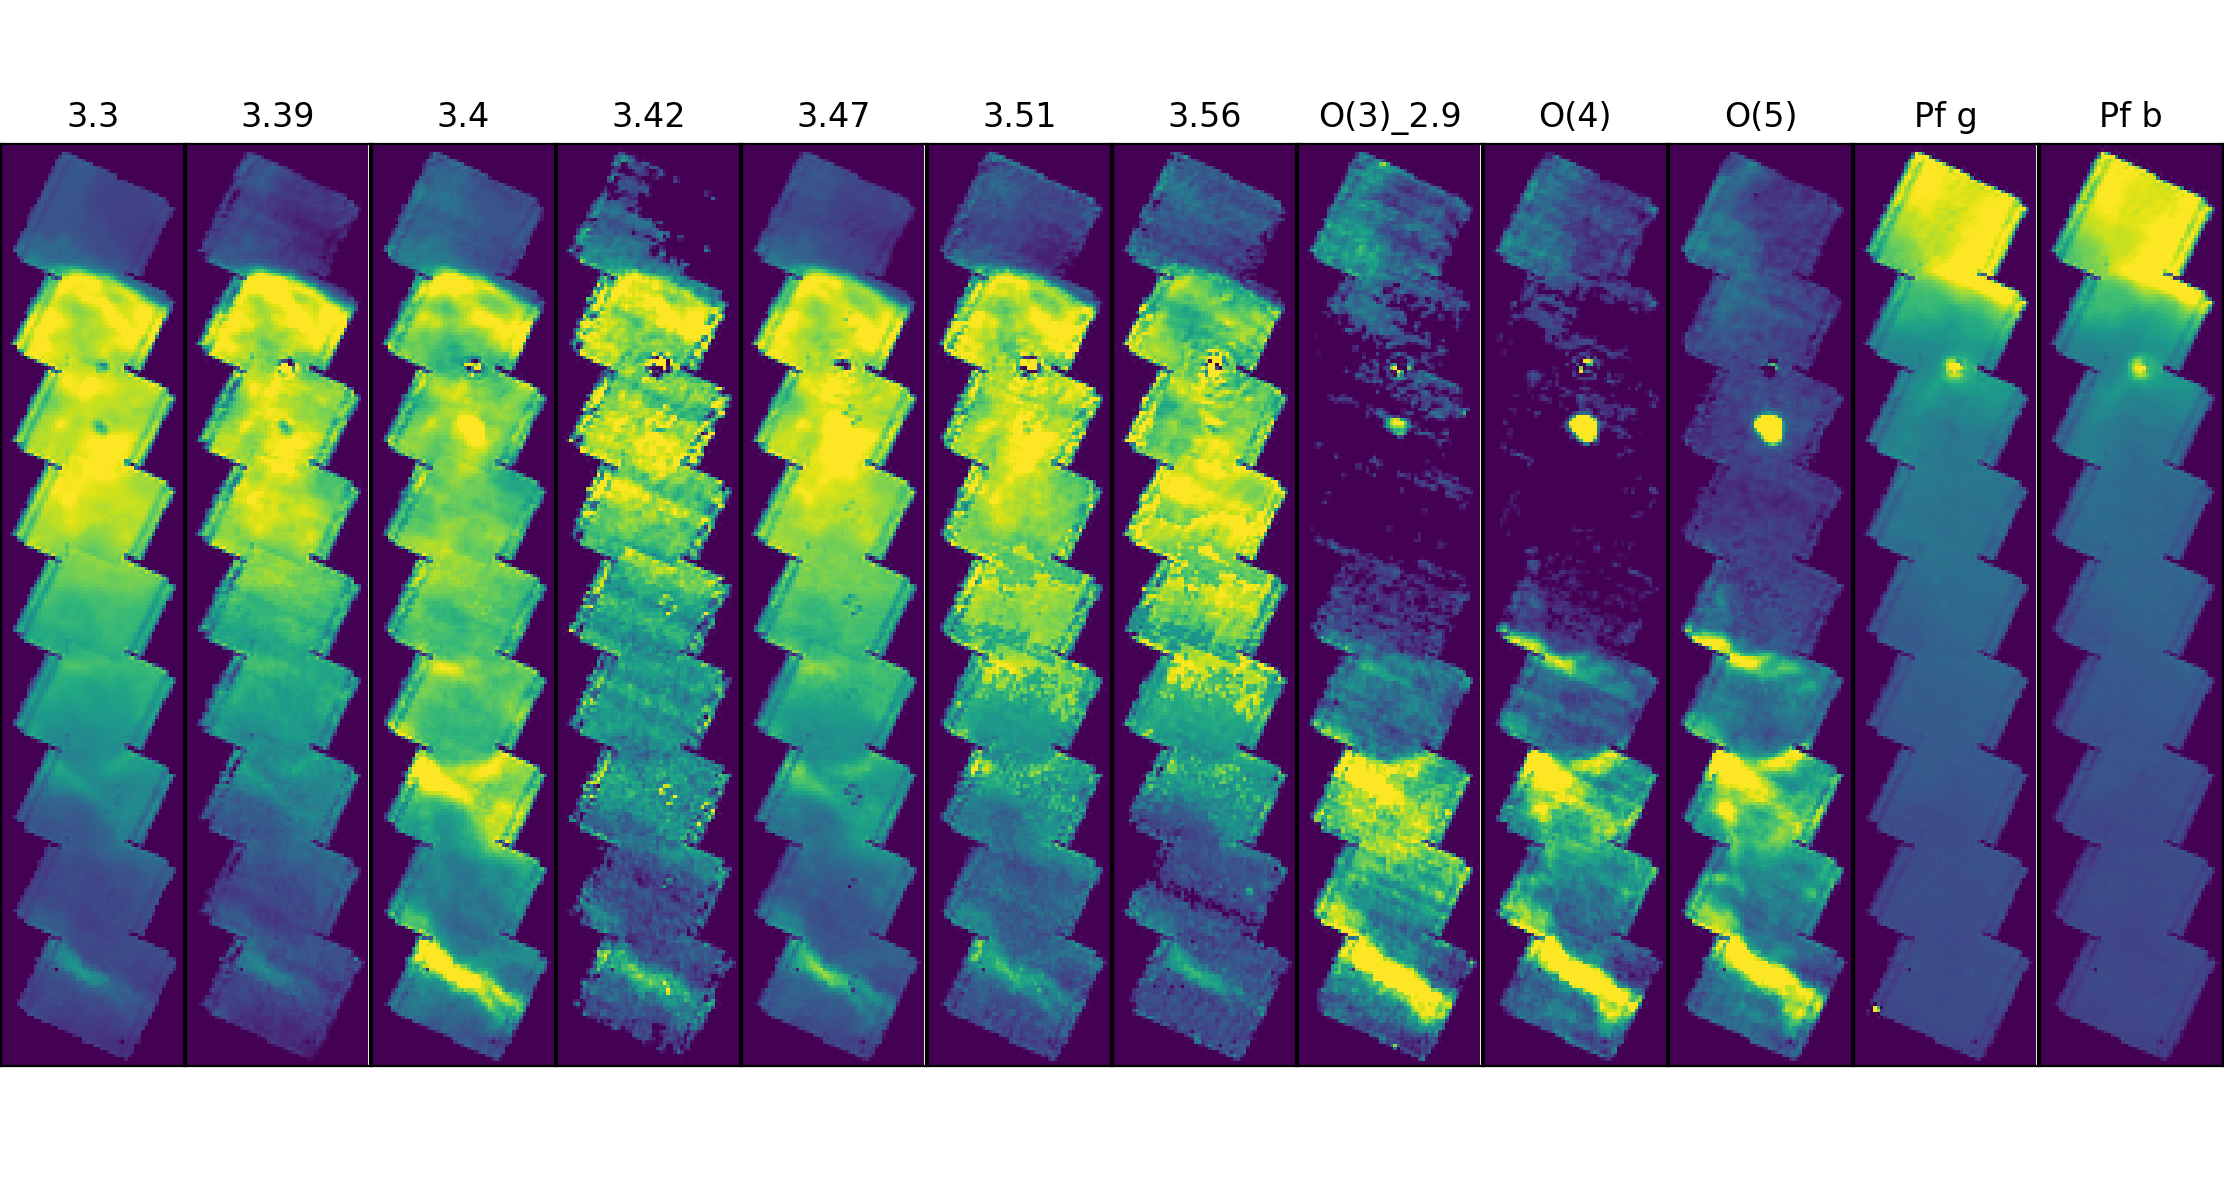

# end 